In [1]:
# ! pip install omegaconf

In [2]:
from omegaconf import OmegaConf

In [3]:
# model_cfg_file = './conf/model/siren/explore_siren.yaml'
model_cfg_file = './conf/model/split/lin10_posenc.yaml'
training_cfg_file = './conf/exp/image_fitting/baseline.yaml'

In [4]:
cfg = OmegaConf.load(training_cfg_file)
cfg['model'] = OmegaConf.load(model_cfg_file)

In [5]:
cfg

{'total_steps': 5000, 'device': 'cuda:0', 'optimizer': {'_target_': 'torch.optim.Adam', 'lr': 0.0001}, 'logging': {'steps_til_summary': 200}, 'model': {'_target_': 'spellbook.splitnet.SplitNetLinPosEnc', 'encoding_size': 64, 'in_features': 2, 'out_features': 1, 'hidden_features': 128, 'hidden_layers': 1, 'outermost_linear': False, 'm': 10.0}}

In [6]:
print(OmegaConf.to_yaml(cfg))

total_steps: 5000
device: cuda:0
optimizer:
  _target_: torch.optim.Adam
  lr: 0.0001
logging:
  steps_til_summary: 200
model:
  _target_: spellbook.splitnet.SplitNetLinPosEnc
  encoding_size: 64
  in_features: 2
  out_features: 1
  hidden_features: 128
  hidden_layers: 1
  outermost_linear: false
  m: 10.0



In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
# ! nvidia-smi

# Siren Exploration

This is a colab to explore properties of the Siren MLP, proposed in our work [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren).


We will first implement a streamlined version of Siren for fast experimentation. This lacks the code to easily do baseline comparisons - please refer to the main code for that - but will greatly simplify the code!

**Make sure that you have enabled the GPU under Edit -> Notebook Settings!**

We will then reproduce the following results from the paper: 
* [Fitting an image](#section_1)
* [Fitting an audio signal](#section_2)
* [Solving Poisson's equation](#section_3)
* [Initialization scheme & distribution of activations](#activations)
* [Distribution of activations is shift-invariant](#shift_invariance)

We will also explore Siren's [behavior outside of the training range](#out_of_range).

Let's go! First, some imports, and a function to quickly generate coordinate grids.

In [9]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time
from tqdm.auto import tqdm

Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

And finally, differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.

In [10]:
from spellbook import count_parameters, instantiate

In [11]:
device = cfg['device']

In [12]:
model = instantiate(cfg['model']).to(device)
count_parameters(model)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| net.0.linear.weight |   65536    |
|  net.0.linear.bias  |    512     |
| net.1.linear.weight |   65536    |
|  net.1.linear.bias  |    512     |
| net.2.linear.weight |    512     |
|  net.2.linear.bias  |     4      |
+---------------------+------------+
Total Trainable Params: 132612


132612

In [13]:
optimizer = instantiate(cfg['optimizer'], params=model.parameters())

Let's instantiate the dataset and our Siren. As pixel coordinates are 2D, the siren has 2 input features, and since the image is grayscale, it has one output channel.

In [14]:
from spellbook.image import ImageFitting, gradient, laplace

In [15]:
cameraman = ImageFitting(256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.to(device), ground_truth.to(device)

/opt/conda/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0, Total loss 0.324129


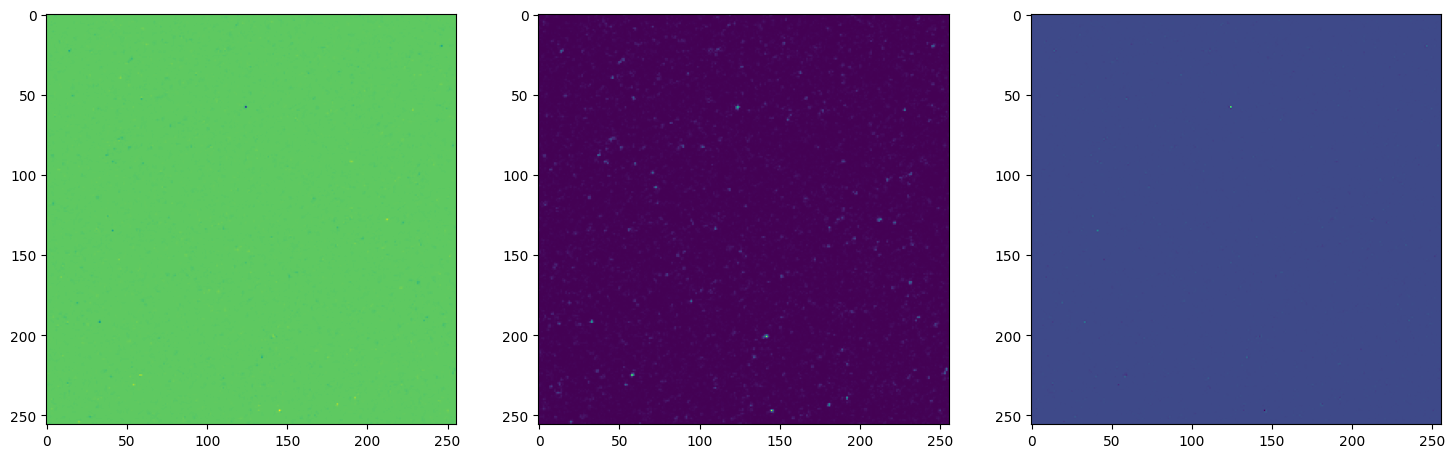

/opt/conda/lib/python3.7/site-packages/torch/autograd/__init__.py:199: UserWarning: operator() profile_node %418 : int[] = prim::profile_ivalue(%416)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


Step 200, Total loss 0.288307


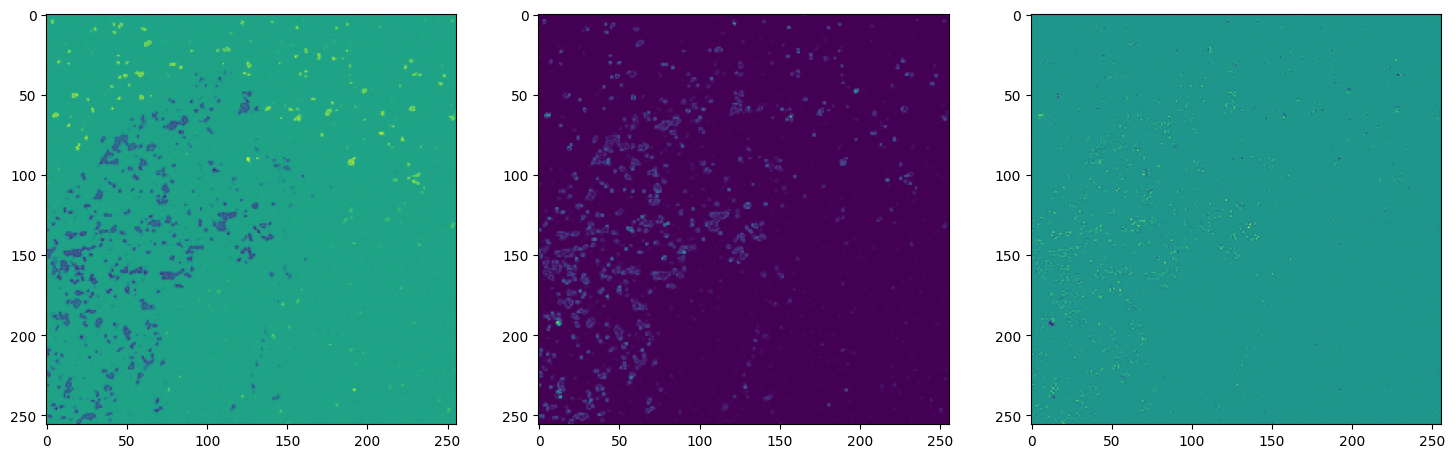

Step 400, Total loss 0.058126


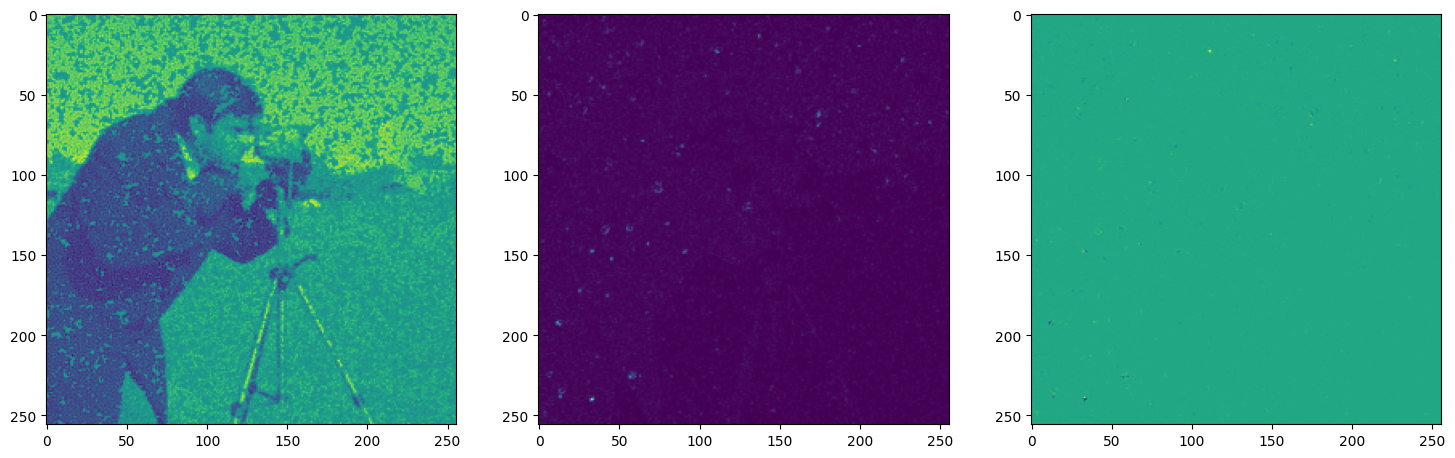

Step 600, Total loss 0.010826


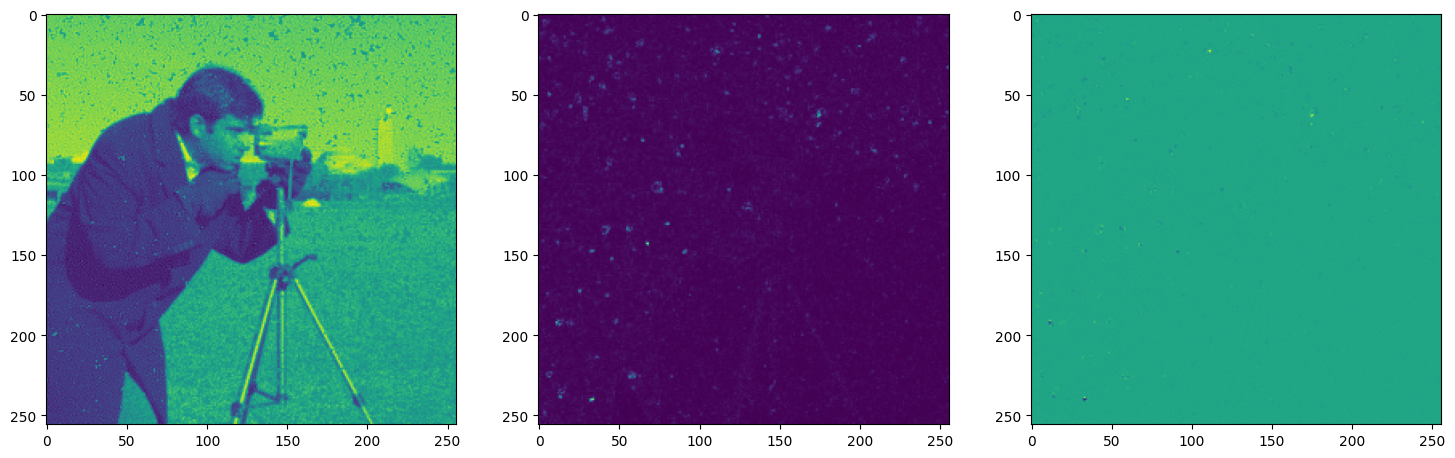

Step 800, Total loss 0.003774


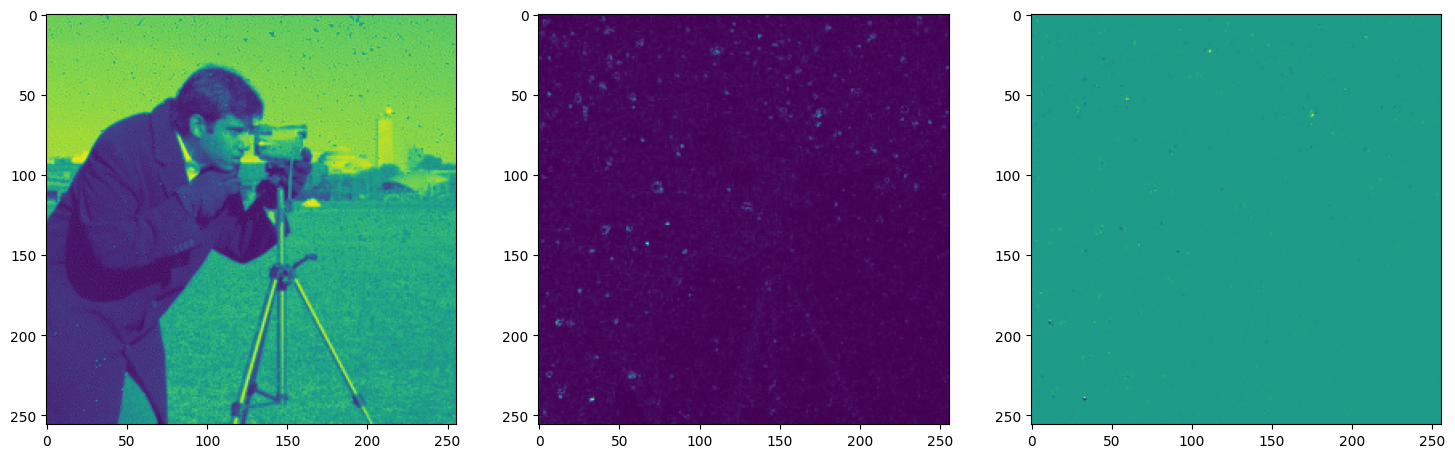

Step 1000, Total loss 0.001743


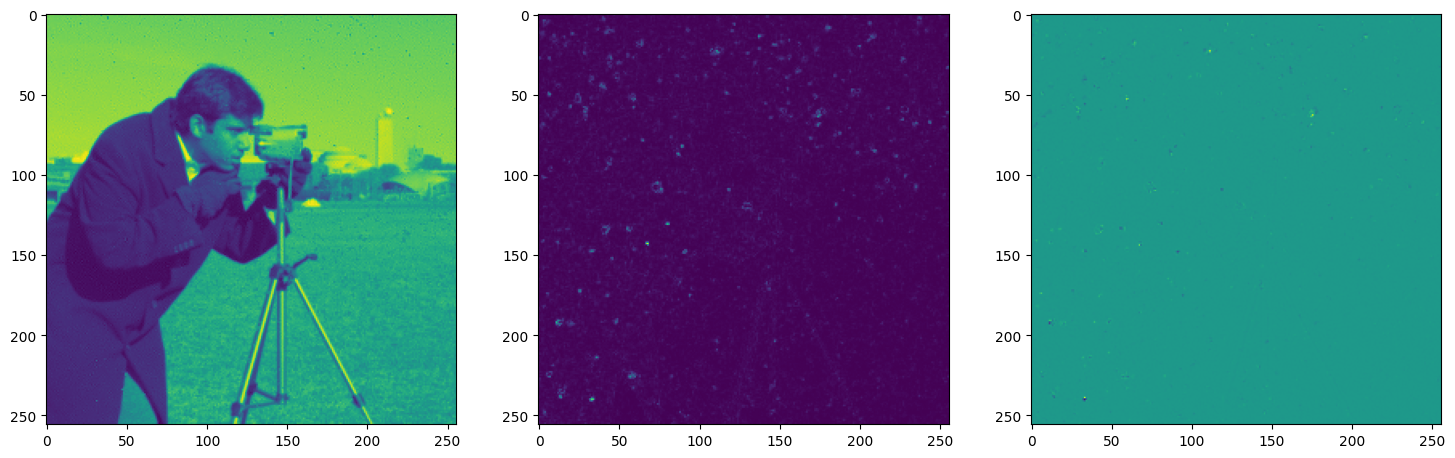

Step 1200, Total loss 0.000938


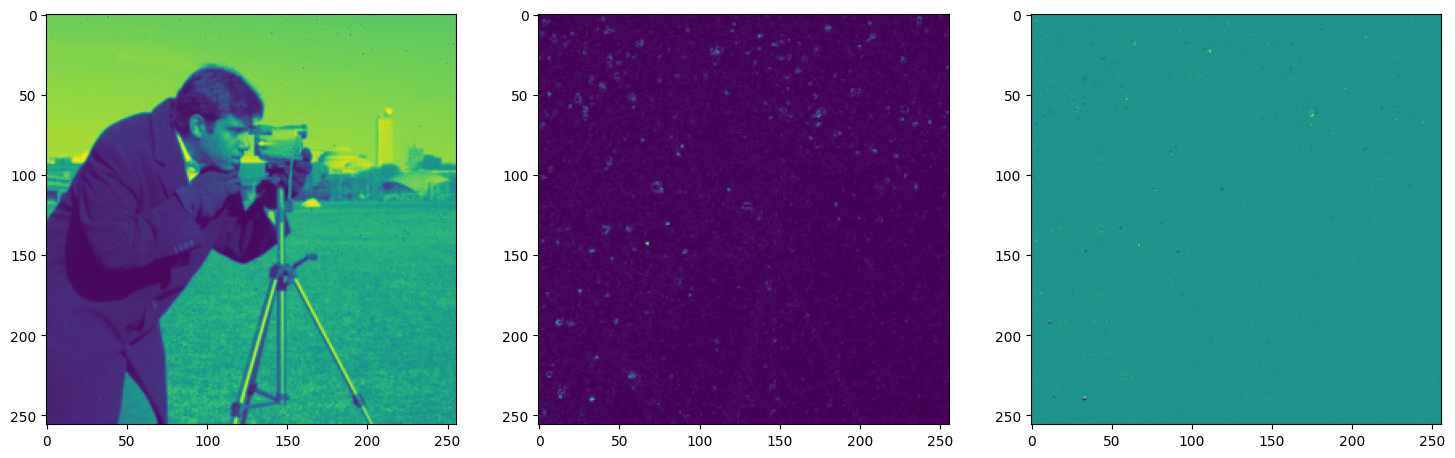

Step 1400, Total loss 0.000559


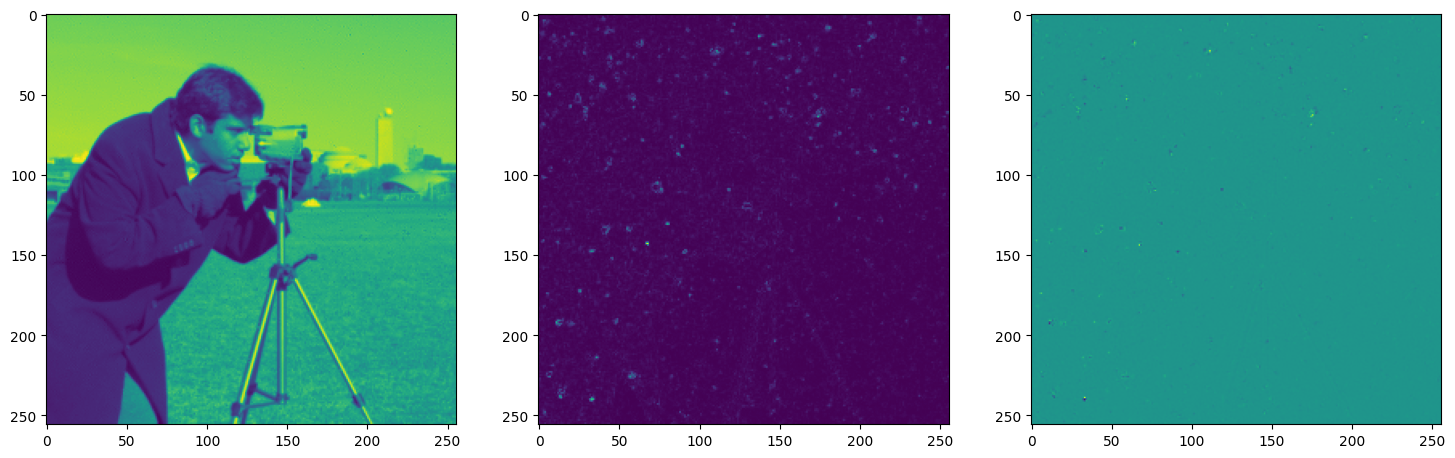

Step 1600, Total loss 0.000354


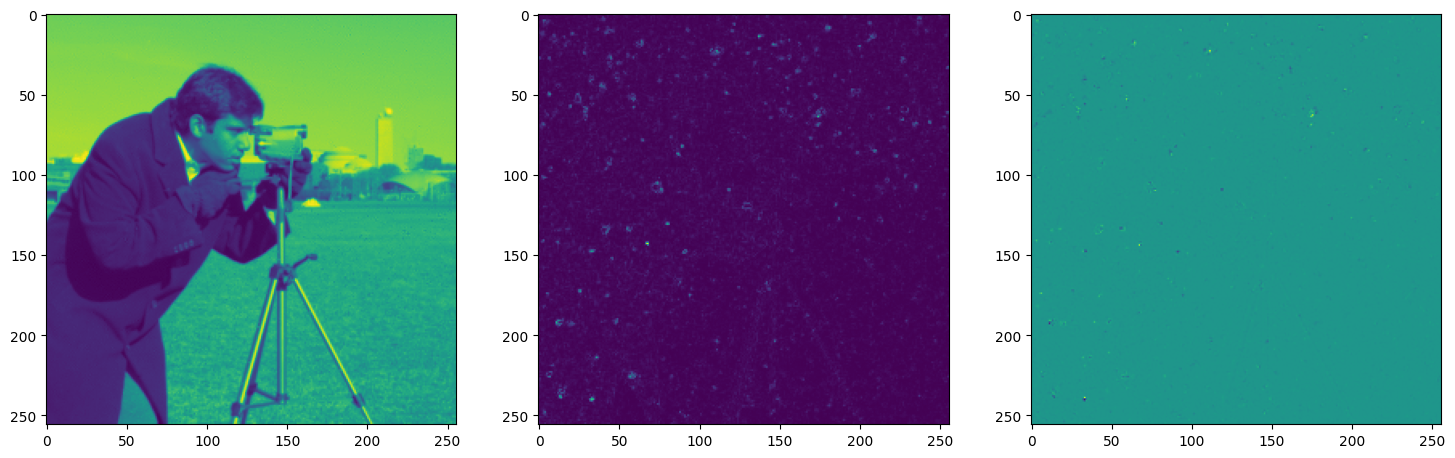

Step 1800, Total loss 0.000231


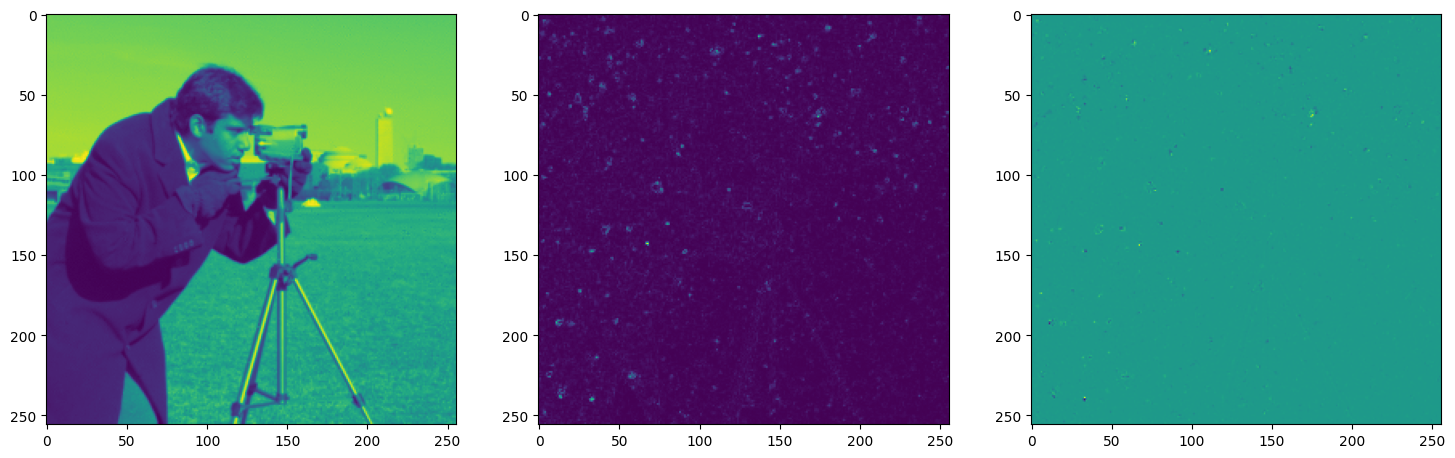

Step 2000, Total loss 0.000151


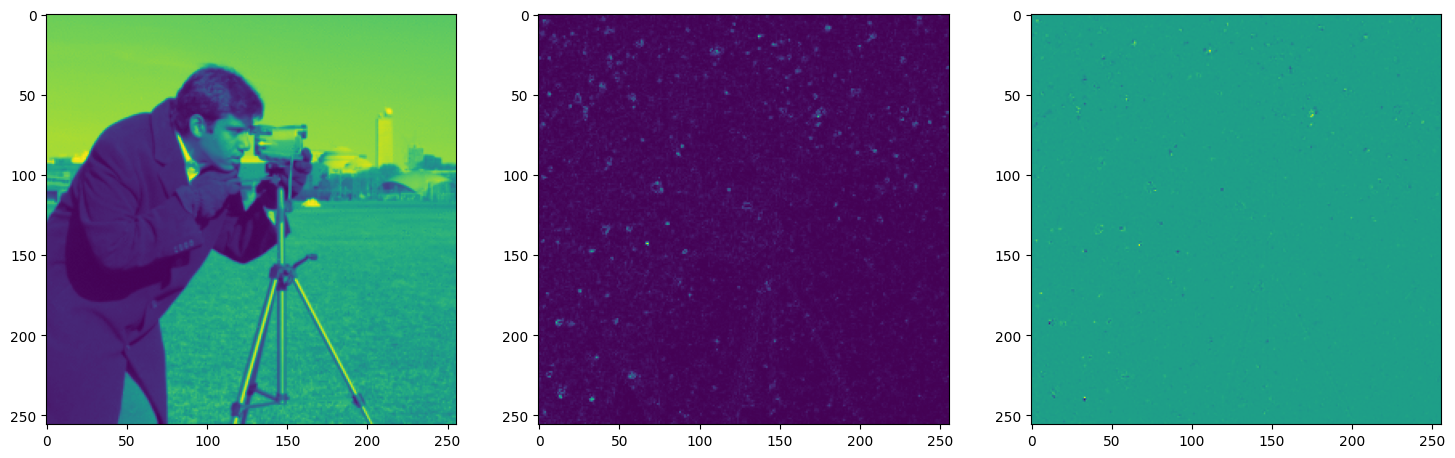

Step 2200, Total loss 0.000103


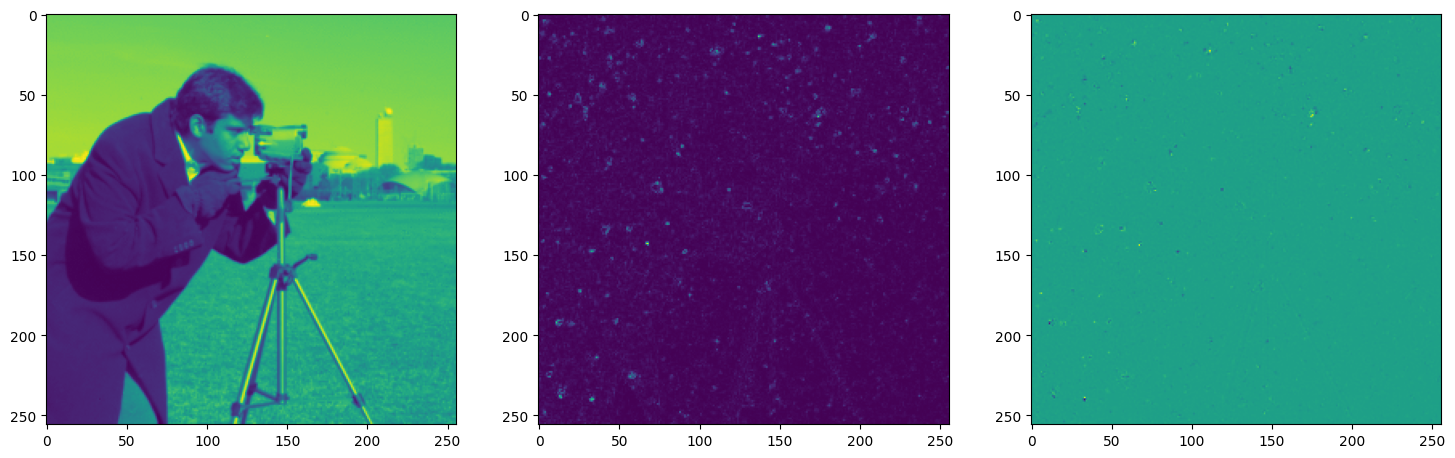

In [ ]:
total_steps = cfg['total_steps']
steps_til_summary = cfg['logging']['steps_til_summary']


pbar = tqdm(range(total_steps))
for step in pbar:
    coords = model_input.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
    model_output = model(coords)    
    loss = ((model_output - ground_truth)**2).mean()

    pbar.set_description(f'loss={loss.item():.4e}')
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(256,256).detach().numpy())
        axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256,256).detach().numpy())
        axes[2].imshow(img_laplacian.cpu().view(256,256).detach().numpy())
        plt.show()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
break

<a id='out_of_range'></a>
## Case study: Siren periodicity & out-of-range behavior

It is known that the sum of two periodic signals is itself periodic with a period that is equal to the least common multiple of the periods of the two summands, if and only if the two periods are rational multiples of each other. If the ratio of the two periods is irrational, then their sum will *not* be periodic itself.

Due to the floating-point representation in neural network libraries, this case cannot occur in practice, and all functions parameterized by Siren indeed have to be periodic.

Yet, the period of the resulting function may in practice be several orders of magnitudes larger than the period of each Siren neuron!

Let's test this with two sines.

In [ ]:
# with torch.no_grad():
#     coords = get_mgrid(2**10, 1) * 5 * np.pi
    
#     sin_1 = torch.sin(coords)
#     sin_2 = torch.sin(coords * 2)
#     sum = sin_1 + sin_2
    
#     fig, ax = plt.subplots(figsize=(16,2))
#     ax.plot(coords, sum)
#     ax.plot(coords, sin_1)
#     ax.plot(coords, sin_2)
#     plt.title("Rational multiple")
#     plt.show()
    
#     sin_1 = torch.sin(coords)
#     sin_2 = torch.sin(coords * np.pi)
#     sum = sin_1 + sin_2
    
#     fig, ax = plt.subplots(figsize=(16,2))
#     ax.plot(coords, sum)
#     ax.plot(coords, sin_1)
#     ax.plot(coords, sin_2)
#     plt.title("Pseudo-irrational multiple")
#     plt.show()

Though the second plot looks periodic, closer inspection shows that the period of the blue line is indeed larger than the range we're sampling here. 

Let's take a look at what the Siren we just trained looks like outside its training domain!

In [ ]:
# with torch.no_grad():
#     out_of_range_coords = get_mgrid(1024, 2) * 50
#     model_out, _ = img_siren(out_of_range_coords.to(device))
    
#     fig, ax = plt.subplots(figsize=(16,16))
#     ax.imshow(model_out.cpu().view(1024,1024).numpy())
#     plt.show()

Though there is some self-similarity, the signal is not repeated on this range of (-50, 50).

<a id='section_3'></a>
## Solving Poisson's equation

Now, let's make it a bit harder. Let's say we want to reconstruct an image but we only have access to its gradients!

That is, we now seek the function $\Phi$ such that:
$\mathcal{L}=\int_{\Omega} \lVert \nabla\Phi(\mathbf{x}) - \nabla f(\mathbf{x}) \rVert\mathrm{d}\mathbf{x}$
 is minimized, in which $\Omega$ is the domain of the image. 

In [ ]:
import scipy.ndimage
    
class PoissonEqn(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_cameraman_tensor(sidelength)
        
        # Compute gradient and laplacian       
        grads_x = scipy.ndimage.sobel(img.numpy(), axis=1).squeeze(0)[..., None]
        grads_y = scipy.ndimage.sobel(img.numpy(), axis=2).squeeze(0)[..., None]
        grads_x, grads_y = torch.from_numpy(grads_x), torch.from_numpy(grads_y)
                
        self.grads = torch.stack((grads_x, grads_y), dim=-1).view(-1, 2)
        self.laplace = scipy.ndimage.laplace(img.numpy()).squeeze(0)[..., None]
        self.laplace = torch.from_numpy(self.laplace)
        
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.coords, {'pixels':self.pixels, 'grads':self.grads, 'laplace':self.laplace}

#### Instantiate SIREN model

In [ ]:
from spellbook import count_parameters

In [ ]:
cameraman_poisson = PoissonEqn(128)
dataloader = DataLoader(cameraman_poisson, batch_size=1, pin_memory=True, num_workers=0)

poisson_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                      hidden_layers=3, outermost_linear=True)
poisson_siren.to(device)

count_parameters(poisson_siren)

In [ ]:
model_input, gt = next(iter(dataloader))
gt = {key: value.to(device) for key, value in gt.items()}
model_input = model_input.to(device)

In [ ]:
model_input

In [ ]:
from spellbook.splitnet import SplitNet, SplitNetManager

poisson_siren = SplitNet(in_features=2, out_features=1, hidden_features=128, 
                      hidden_layers=1, outermost_linear=True)
count_parameters(poisson_siren)

# man = SplitNetManager(poisson_siren)
# man.init_01(model_input.cpu())

poisson_siren = poisson_siren.to(device)


#### Define the loss function

In [ ]:
def gradients_mse(model_output, coords, gt_gradients):
    # compute gradients on the model
    gradients = gradient(model_output, coords)
    # compare them with the ground-truth
    gradients_loss = torch.mean((gradients - gt_gradients).pow(2).sum(-1))
    return gradients_loss

#### Train the model

In [ ]:
total_steps = 1000
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=poisson_siren.parameters())



for step in range(total_steps):
    start_time = time.time()

    
    coords = model_input.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
    model_output = poisson_siren.forward(coords)

    train_loss = gradients_mse(model_output, coords, gt['grads'])

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f, iteration time %0.6f" % (step, train_loss, time.time() - start_time))

        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].imshow(model_output.cpu().view(128,128).detach().numpy())
        axes[1].imshow(img_grad.cpu().norm(dim=-1).view(128,128).detach().numpy())
        axes[2].imshow(img_laplacian.cpu().view(128,128).detach().numpy())
        plt.show()
        
    optim.zero_grad()
    train_loss.backward()
    optim.step()

SIREN

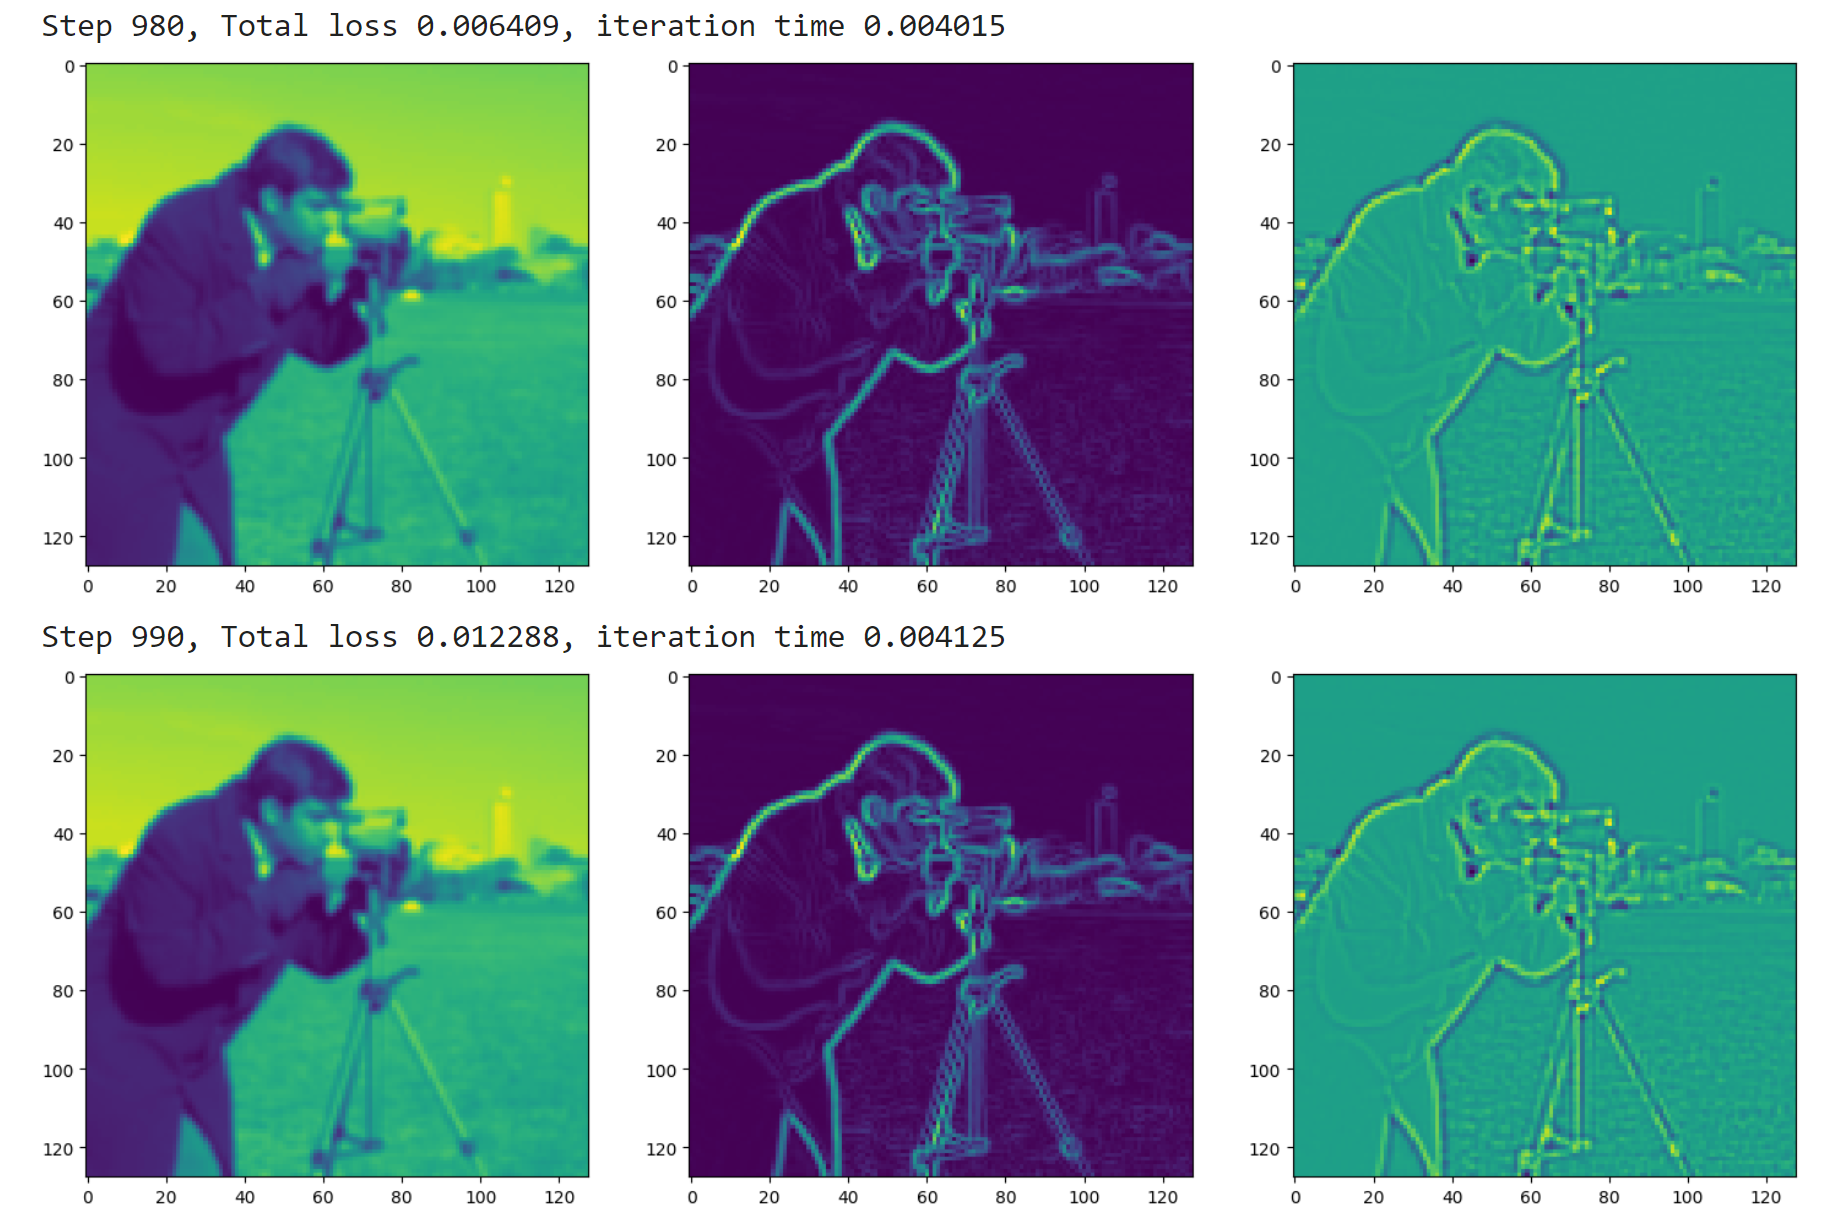

<a id='activations'></a>
## Initialization scheme & distribution of activations

We now reproduce the empirical result on the distribution of activations, and will thereafter show empirically that the distribution of activations is shift-invariant as well! 

In [ ]:
from collections import OrderedDict
import matplotlib
import numpy.fft as fft
import scipy.stats as stats


def eformat(f, prec, exp_digits):
    s = "%.*e"%(prec, f)
    mantissa, exp = s.split('e')
    # add 1 to digits as 1 is taken by sign +/-
    return "%se%+0*d"%(mantissa, exp_digits+1, int(exp))

def format_x_ticks(x, pos):
    """Format odd tick positions
    """
    return eformat(x, 0, 1)

def format_y_ticks(x, pos):
    """Format odd tick positions
    """
    return eformat(x, 0, 1)

def get_spectrum(activations):
    n = activations.shape[0]

    spectrum = fft.fft(activations.numpy().astype(np.double).sum(axis=-1), axis=0)[:n//2]
    spectrum = np.abs(spectrum)

    max_freq = 100                
    freq = fft.fftfreq(n, 2./n)[:n//2]
    return freq[:max_freq], spectrum[:max_freq]


def plot_all_activations_and_grads(activations):
    num_cols = 4
    num_rows = len(activations)
    
    fig_width = 5.5
    fig_height = num_rows/num_cols*fig_width
    fig_height = 9
    
    fontsize = 5
        
    fig, axs = plt.subplots(num_rows, num_cols, gridspec_kw={'hspace': 0.3, 'wspace': 0.2},
                            figsize=(fig_width, fig_height), dpi=300)
    
    axs[0][0].set_title("Activation Distribution", fontsize=7, fontfamily='serif', pad=5.)
    axs[0][1].set_title("Activation Spectrum", fontsize=7, fontfamily='serif', pad=5.)
    axs[0][2].set_title("Gradient Distribution", fontsize=7, fontfamily='serif', pad=5.)
    axs[0][3].set_title("Gradient Spectrum", fontsize=7, fontfamily='serif', pad=5.)

    x_formatter = matplotlib.ticker.FuncFormatter(format_x_ticks)
    y_formatter = matplotlib.ticker.FuncFormatter(format_y_ticks)

    spec_rows = []
    for idx, (key, value) in enumerate(activations.items()):    
        grad_value = value.grad.cpu().detach().squeeze(0)
        flat_grad = grad_value.view(-1)
        axs[idx][2].hist(flat_grad, bins=256, density=True)
        
        value = value.cpu().detach().squeeze(0) # (1, num_points, 256)
        n = value.shape[0]
        flat_value = value.view(-1)
            
        axs[idx][0].hist(flat_value, bins=256, density=True)
                
        if idx>1:
            if not (idx)%2:
                x = np.linspace(-1, 1., 500)
                axs[idx][0].plot(x, stats.arcsine.pdf(x, -1, 2), 
                                 linestyle=':', markersize=0.4, zorder=2)
            else:
                mu = 0
                variance = 1
                sigma = np.sqrt(variance)
                x = np.linspace(mu - 3*sigma, mu + 3*sigma, 500)
                axs[idx][0].plot(x, stats.norm.pdf(x, mu, sigma), 
                                 linestyle=':', markersize=0.4, zorder=2)
        
        activ_freq, activ_spec = get_spectrum(value)
        axs[idx][1].plot(activ_freq, activ_spec)
        
        grad_freq, grad_spec = get_spectrum(grad_value)
        axs[idx][-1].plot(grad_freq, grad_spec)
        
        for ax in axs[idx]:
            ax.tick_params(axis='both', which='major', direction='in',
                                    labelsize=fontsize, pad=1., zorder=10) 
            ax.tick_params(axis='x', labelrotation=0, pad=1.5, zorder=10) 

            ax.xaxis.set_major_formatter(x_formatter)
            ax.yaxis.set_major_formatter(y_formatter)

In [ ]:
input_signal.shape

In [ ]:
import lovely_tensors as lt
lt.monkey_patch()

In [ ]:
for key, value in activations.items():
    print(key)
    display(value.plt)
    display(value.grad.plt)    

In [ ]:
activations

In [ ]:
model = Siren(in_features=1, hidden_features=2048, 
              hidden_layers=10, out_features=1, outermost_linear=True)

input_signal = torch.linspace(-1, 1, 65536//4).view(1, 65536//4, 1)
activations = model.forward_with_activations(input_signal, retain_grad=True)
output = activations[next(reversed(activations))]

# Compute gradients. Because we have retain_grad=True on 
# activations, each activation stores its own gradient!
output.mean().backward()

plot_all_activations_and_grads(activations)

Note how the activations of Siren always alternate between a standard normal distribution with standard deviation one, and an arcsine distribution. If you have a beefy computer, you can put this to the extreme and increase the number of layers - this property holds even for more than 50 layers!

<a id='shift_invariance'></a>
## Distribution of activations is shift-invariant

One of the key properties of the periodic sine nonlinearity is that it affords a degree of shift-invariance. Consider the first layer of a Siren: You can convince yourself that this layer can easily learn to map two different coordinates to *the same set of activations*. This means that whatever layers come afterwards will apply the same function to these two sets of coordinates.

Moreoever, the distribution of activations similarly are shift-invariant. Let's shift our input signal by 1000 and re-compute the activations:

In [ ]:
input_signal = torch.linspace(-1, 1, 65536//4).view(1, 65536//4, 1) + 1000
activations = model.forward_with_activations(input_signal, retain_grad=True)
output = activations[next(reversed(activations))]

# Compute gradients. Because we have retain_grad=True on 
# activations, each activation stores its own gradient!
output.mean().backward()

plot_all_activations_and_grads(activations)

As we can see, the distributions of activations didn't change at all - they are perfectly invariant to the shift.